# NLP and Topic Modeling - Watch Reviews

In this project, I will use unsupervised learning models to cluster the unlabeled documents of watch reviews into different groups. And then visualize the results and label them latent topic.

## Contents

* [Part 1: Load Data](#Part-1:-Load-Data)
* [Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3:-TF-IDF)
* [Part 4: K-means clustering](#Part-4:-K-means-clustering)
* [Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
* [Part 6: Optimal classify](#Part-6:-Optimal-Classify-)
* [Part 7: Analyze topic through the business lens](#Part-7:-Analyze-topic---through-the-business-lens)


# Part 1: Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# data Link: https://drive.google.com/file/d/192JMR7SIqoa14vrs7Z9BXO3iK89pimJL/view
id = "192JMR7SIqoa14vrs7Z9BXO3iK89pimJL"
file = drive.CreateFile({'id':id})
file.GetContentFile('watch_reviews.tsv')
watch_df = pd.read_csv('watch_reviews.tsv',  sep='\t', error_bad_lines=False)
watch_df.head()

<ipython-input-2-4aa1d761c0c0>:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  watch_df = pd.read_csv('watch_reviews.tsv',  sep='\t', error_bad_lines=False)
Skipping line 8704: expected 15 fields, saw 22
Skipping line 16933: expected 15 fields, saw 22
Skipping line 23726: expected 15 fields, saw 22

Skipping line 85637: expected 15 fields, saw 22

Skipping line 132136: expected 15 fields, saw 22
Skipping line 158070: expected 15 fields, saw 22
Skipping line 166007: expected 15 fields, saw 22
Skipping line 171877: expected 15 fields, saw 22
Skipping line 177756: expected 15 fields, saw 22
Skipping line 181773: expected 15 fields, saw 22
Skipping line 191085: expected 15 fields, saw 22
Skipping line 196273: expected 15 fields, saw 22
Skipping line 196331: expected 15 fields, saw 22

Skipping line 197000: expected 15 fields, saw 22
Skipping line 197011: expected 15 fields, saw 22
Skipping line

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [3]:
watch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960204 non-null  object
 1   customer_id        960204 non-null  int64 
 2   review_id          960204 non-null  object
 3   product_id         960204 non-null  object
 4   product_parent     960204 non-null  int64 
 5   product_title      960202 non-null  object
 6   product_category   960204 non-null  object
 7   star_rating        960204 non-null  int64 
 8   helpful_votes      960204 non-null  int64 
 9   total_votes        960204 non-null  int64 
 10  vine               960204 non-null  object
 11  verified_purchase  960204 non-null  object
 12  review_headline    960197 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960200 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [4]:
watch_df.nunique()

marketplace               1
customer_id          719522
review_id            960204
product_id           149658
product_parent       141818
product_title        143436
product_category          1
star_rating               5
helpful_votes           284
total_votes             309
vine                      2
verified_purchase         2
review_headline      456703
review_body          873427
review_date            4173
dtype: int64

Ensure that there are no duplicates

In [5]:
watch_df["review_id"].duplicated().sum()

0

Drop na reviews

In [6]:
watch_df.dropna(subset = ["review_body"], inplace = True)

In [7]:
watch_df.reset_index(inplace = True, drop = True)

In [8]:
watch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960056 entries, 0 to 960055
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960056 non-null  object
 1   customer_id        960056 non-null  int64 
 2   review_id          960056 non-null  object
 3   product_id         960056 non-null  object
 4   product_parent     960056 non-null  int64 
 5   product_title      960054 non-null  object
 6   product_category   960056 non-null  object
 7   star_rating        960056 non-null  int64 
 8   helpful_votes      960056 non-null  int64 
 9   total_votes        960056 non-null  int64 
 10  vine               960056 non-null  object
 11  verified_purchase  960056 non-null  object
 12  review_headline    960049 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960052 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [13]:
data_1000 = watch_df.loc[:999,'review_body'].tolist()
data_1000[:10]

['Absolutely love this watch! Get compliments almost every time I wear it. Dainty.',
 'I love this watch it keeps time wonderfully.',
 'Scratches',
 'It works well on me. However, I found cheaper prices in other places after making the purchase',
 "Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch",
 'i love this watch for my purpose, about the people complaining should of done their research better before buying. dumb people.',
 'for my wife and she loved it, looks great and a 

In [14]:
data_2000 = watch_df['review_body'].sample(n=2000, random_state=4).tolist()
data_2000[:20]

['cute',
 'Great stuff!',
 "Per the description, this watch is supposed to have a fold-over band, but it doesn't. It is just a simple clasp. Although you can't see the clasp in the diagram, you can see the clasp if you watched the video. I returned the watch. If it had the right clasp, I probably would have kept the watch since it looked quite sturdy.",
 'Below standard!  Battery stopped second day I had it and the timers do not work would not recommend to Anyone!',
 'Great looking watch..just wish it was easier to program. Very complicated.',
 "Nice looking.  My husband very much likes it.  However, I'm a light sleeper, he's a heavy sleeper...didn't wake either of us up.  He's a snooze hitter and that is a challenge for him, too.  NICE watch.  just didn't do the job.",
 'Good',
 'great one<br /><br />Accurate and elegant',
 'I have had this watch for a while and have gotten a lot of compliments for it. It looks very nice and is my &#34;go to&#34; watch when I want to wear a statement 

In [15]:
data_10000 = watch_df['review_body'].sample(n=10000, random_state=421).tolist()
data_10000[:10]

["I'm not a watch guru, but when I removed this watch from the box I was pleasantly surprised at how solid and well constructed it felt.  I purchased the orange faced version and was very happy with the coloration.  The band is very attractive as well and feels solid without being too clunky.  If you prefer a medium-small watch face, you will likely be happy with this one as it fits my smaller wrist quite nicely.  I like this watch soo much that I've considered buying the same model in a different color.",
 'This is the third or fourth Anne Klein watch I have bought and I love them all! alays get lots of compliments on them too. Look forward to buying some more at the next sale.',
 'it arrived with dead battery',
 'My son loved the watch.',
 'Cute watch however I found out after I purchased it that it can be found at many party stores in the Spiderman birthday section for less than half what I paid for it online.  It is $2.99 at one of the stores I shopped at after purchasing this item

# Part 2: Tokenizing and Stemming

Stop word is to not take word like "a", "the", "or", because they don't convey significant meaning
Stemming is the pprocess of breaking a word dow no root like watches to watch

In [16]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("br") #html <br>
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("watch")

print("Length of stopword: " + str(len(stopwords)))

Length of stopword: 183


In this case, there will be a lot of "watch" words, to avoid that the word watch affects our result we will do stemming to ensure that watches is also ignored too.

In [17]:
from nltk.stem.snowball import SnowballStemmer
# other option: from nltk.stem import WordNetLemmatizer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = []
    # add all words to the list
    for word in nltk.word_tokenize(text):
      tokens.append(word.lower())
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    first_filter = []
    for token in tokens:
      if token.isalpha():
        first_filter.append(token)
    stems = [stemmer.stem(t) for t in first_filter]
    final_filter = []
    for stem in stems:
      if stem not in stopwords:
        final_filter.append(stem)
    return final_filter



Test the function above

In [18]:
data_1000[8]

"Watch is perfect. Rugged with the metal &#34;Bull Bars&#34;. The red accents are a great touch and I get compliments when wearing it. If you are worried about being able to read this in sunlight or in the dark don't! The LED ilumination works great! I might even get this in a different color for my next G-Shock purchase!"

In [19]:
tokenization_and_stemming(data_1000[8])

['perfect',
 'rug',
 'metal',
 'bull',
 'bar',
 'red',
 'accent',
 'great',
 'touch',
 'get',
 'compliment',
 'wear',
 'worri',
 'abl',
 'read',
 'sunlight',
 'dark',
 'led',
 'ilumin',
 'work',
 'great',
 'might',
 'even',
 'get',
 'differ',
 'color',
 'next',
 'purchas']

# Part 3: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words in the dictionary
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram

# 1_gram
tfidf_model_1 = TfidfVectorizer(max_df = 0.99, max_features=1000,
                                 min_df = 0.01, stop_words='english',
                                use_idf=True, tokenizer = tokenization_and_stemming, ngram_range=(1,1))
#1 and 2_gram
tfidf_model_2 = TfidfVectorizer(max_df = 0.99, max_features=2000,
                                 min_df = 0.01, stop_words='english',
                                 use_idf=True, tokenizer = tokenization_and_stemming, ngram_range=(1,2))

#1-gram, 2-gram, 3-gram
tfidf_model_3 = TfidfVectorizer(max_df = 0.99, max_features=10000,
                                 min_df = 0.01, stop_words='english',
                                 use_idf=True, tokenizer = tokenization_and_stemming, ngram_range=(1,3))

tfidf_matrix_1 = tfidf_model_1.fit_transform(data_1000)
tfidf_matrix_2 = tfidf_model_2.fit_transform(data_2000)
tfidf_matrix_3 = tfidf_model_3.fit_transform(data_10000)


print ("tfidf_matrix_1 Reviews: " + str(tfidf_matrix_1.shape[0]))
print ("tfidf_matrix_1 Terms: " + str(tfidf_matrix_1.shape[1]))
print ("tfidf_matrix_2 Reviews: " + str(tfidf_matrix_2.shape[0]))
print ("tfidf_matrix_2 Terms: " + str(tfidf_matrix_2.shape[1]))
print ("tfidf_matrix_3 Reviews: " + str(tfidf_matrix_3.shape[0]))
print ("tfidf_matrix_3 Terms: " + str(tfidf_matrix_3.shape[1]))


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

tfidf_matrix_1 Reviews: 1000
tfidf_matrix_1 Terms: 245
tfidf_matrix_2 Reviews: 2000
tfidf_matrix_2 Terms: 386
tfidf_matrix_3 Reviews: 10000
tfidf_matrix_3 Terms: 387


In [21]:
data_1000[8]

"Watch is perfect. Rugged with the metal &#34;Bull Bars&#34;. The red accents are a great touch and I get compliments when wearing it. If you are worried about being able to read this in sunlight or in the dark don't! The LED ilumination works great! I might even get this in a different color for my next G-Shock purchase!"

In [22]:
tfidf_matrix_1.toarray()[8]

array([0.32249123, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.23652831, 0.        , 0.        , 0.28838333,
       0.        , 0.        , 0.        , 0.        , 0.30783297,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2959858 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [23]:
len(tfidf_matrix_1.toarray()[8])

245

Save words after TF_IDF

In [24]:
tdidf_words_1 = tfidf_model_1.get_feature_names_out()
tdidf_words_2 = tfidf_model_2.get_feature_names_out()
tdidf_words_3 = tfidf_model_3.get_feature_names_out()

tdidf_words_2

array(['abl', 'absolut', 'accur', 'actual', 'adjust', 'ago', 'alarm',
       'alreadi', 'alway', 'amaz', 'amazon', 'ani', 'anoth', 'anyon',
       'anyth', 'appear', 'arriv', 'attract', 'automat', 'away', 'awesom',
       'bad', 'band', 'batteri', 'beat', 'beauti', 'becaus', 'befor',
       'best', 'better', 'big', 'bigger', 'bit', 'black', 'blue',
       'bought', 'box', 'boyfriend', 'bracelet', 'brand', 'break',
       'bright', 'broke', 'broken', 'button', 'buy', 'ca', 'came', 'care',
       'case', 'casio', 'casual', 'chang', 'cheap', 'check', 'christma',
       'clasp', 'classi', 'clean', 'clear', 'clock', 'close', 'collect',
       'color', 'come', 'comfort', 'compani', 'complaint', 'complet',
       'compliment', 'contact', 'cool', 'correct', 'cost', 'coupl',
       'cover', 'crystal', 'custom', 'cute', 'daili', 'dark', 'date',
       'daughter', 'day', 'dead', 'deal', 'decid', 'definit', 'deliveri',
       'descript', 'design', 'dial', 'differ', 'difficult', 'digit',
       'di

# Part 4: K-means clustering

After generating TDIDF, we can then use cluster or topic models to cluster them in k groups

In [25]:
from sklearn.cluster import KMeans
# numbers of cluster for 3 deferent size of data
num_clusters_1 = 5
num_clusters_2 = 7
num_clusters_3 = 8

km_1 = KMeans(n_clusters = num_clusters_1)
km_1.fit(tfidf_matrix_1)


km_2 = KMeans(n_clusters = num_clusters_2)
km_2.fit(tfidf_matrix_2)



km_3 = KMeans(n_clusters = num_clusters_3)
km_3.fit(tfidf_matrix_3)

#make the labels for each word

clusters_1 = km_1.labels_.tolist()

clusters_2 = km_2.labels_.tolist()
clusters_3 = km_3.labels_.tolist()



clusters_2[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3, 5, 3, 3, 5, 1, 2, 5, 1, 3]

In [26]:
len(clusters_1)

1000

## Result of K_means

In [27]:
product_1 = { 'review': watch_df[:1000].review_body, 'cluster': clusters_1}

product_2 = { 'review': watch_df['review_body'].sample(n=2000, random_state=4), 'cluster': clusters_2}

product_3 = { 'review': watch_df['review_body'].sample(n=10000, random_state=421), 'cluster': clusters_3}

frame_1 = pd.DataFrame(product_1, columns = ['review', 'cluster'])

frame_2 = pd.DataFrame(product_2, columns = ['review', 'cluster'])
frame_3 = pd.DataFrame(product_3, columns = ['review', 'cluster'])

In [28]:
frame_1.head(10)

,review,cluster
0,Absolutely love this watch! Get compliments al...,1
1,I love this watch it keeps time wonderfully.,1
2,Scratches,4
3,"It works well on me. However, I found cheaper ...",4
4,Beautiful watch face. The band looks nice all...,4
5,"i love this watch for my purpose, about the pe...",1
6,"for my wife and she loved it, looks great and ...",3
7,I was about to buy this thinking it was a Swis...,4
8,Watch is perfect. Rugged with the metal &#34;B...,3
9,Great quality and build.<br />The motors are r...,3


In [29]:
frame_2.head(10)

,review,cluster
92111,cute,3
277045,Great stuff!,5
313884,"Per the description, this watch is supposed to...",3
73852,Below standard! Battery stopped second day I ...,3
181656,Great looking watch..just wish it was easier t...,5
956398,Nice looking. My husband very much likes it. ...,1
134788,Good,2
241900,great one<br /><br />Accurate and elegant,5
347795,I have had this watch for a while and have got...,1
690807,My low-end automatic watch never seemed to hav...,3


In [30]:
frame_3.head(10)

,review,cluster
850343,"I'm not a watch guru, but when I removed this ...",7
511345,This is the third or fourth Anne Klein watch I...,3
14320,it arrived with dead battery,5
273083,My son loved the watch.,0
914522,Cute watch however I found out after I purchas...,5
419438,Good visibility when running. Excellent featur...,4
650547,"The watch works, but is flimsy. It's thin. It ...",7
826755,Love my Invicta Pro Diver and want more now! ...,5
761362,Would recommend this to someone who knows abou...,5
574187,I own four of these watches. I love and enjoy...,3


Number of reviews included in each cluster

In [32]:
print ("Frame 1 Num Revies distribution")
frame_1["cluster"].value_counts()

Frame 1 Num Revies distribution


4    644
1    111
3     96
2     76
0     73
Name: cluster, dtype: int64

In [33]:
print ("Frame 2 Num Revies distribution")
frame_2["cluster"].value_counts()

Frame 2 Num Revies distribution


3    1293
5     237
1     124
2     113
4     110
0      89
6      34
Name: cluster, dtype: int64

In [34]:
print ("Frame 3 Num Revies distribution")
frame_3["cluster"].value_counts()

Frame 3 Num Revies distribution


5    4824
3    1528
7    1131
1     936
2     586
6     583
0     240
4     172
Name: cluster, dtype: int64

Cluster center point TF IDF value

In [35]:
km_1.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00887803,
        0.        ],
       [0.        , 0.03772615, 0.        , ..., 0.01222159, 0.01671942,
        0.00400254],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0063978 ,
        0.        ],
       [0.00335928, 0.        , 0.        , ..., 0.00232159, 0.00393023,
        0.02427312],
       [0.00575542, 0.00511457, 0.00387938, ..., 0.00677377, 0.01766158,
        0.01354541]])

In [36]:
km_2.cluster_centers_

array([[0.00416279, 0.01344691, 0.00283696, ..., 0.        , 0.00414563,
        0.00317091],
       [0.        , 0.        , 0.00496988, ..., 0.        , 0.00936325,
        0.00492402],
       [0.        , 0.        , 0.01198864, ..., 0.01650694, 0.00096054,
        0.        ],
       ...,
       [0.        , 0.01821093, 0.        , ..., 0.        , 0.00389658,
        0.00597966],
       [0.        , 0.00234595, 0.00539922, ..., 0.00419121, 0.01453906,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [37]:
km_3.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00368007, 0.00326997, 0.00214329, ..., 0.00358154, 0.01209139,
        0.00160116],
       [0.00087927, 0.00342282, 0.00275785, ..., 0.00209227, 0.00566678,
        0.00072625],
       ...,
       [0.00593193, 0.00291279, 0.00027474, ..., 0.00505528, 0.0209036 ,
        0.00374112],
       [0.00085544, 0.00128302, 0.        , ..., 0.00204715, 0.00193187,
        0.00106204],
       [0.00244543, 0.00231429, 0.00098276, ..., 0.00324434, 0.014815  ,
        0.00244693]])

Biuld clustering result function that outputs the most important 6 words for representing for each cluster

In [58]:
def kmeans_result_output(km, num_clusters, tdidf_words, frame):
  order_centroids = km.cluster_centers_.argsort()[:, ::-1]
  Cluster_keywords_summary = {}
  for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :len(order_centroids) * 3]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tdidf_words[ind])
        print (tdidf_words[ind] + ",", end='')
    print ()

    cluster_reviews = frame[frame.cluster==i].review.tolist()[:3]
    print ("Cluster " + str(i) + " reviews: " + str(len(cluster_reviews)) + " reviews : ")
    print (", ".join(cluster_reviews))
    print ()
    print ()

kmeans_result_output(km_1, num_clusters_1, tdidf_words_1, frame_1)

Cluster 0 words:good,veri,product,price,qualiti,work,love,big,excel,look,seller,time,valu,littl,like,
Cluster 0 reviews: 3 reviews : 
very good, It's a good value, and a good functional watch strap.  It's super wide though, and takes more space on the wrist than I'd like., very good


Cluster 1 words:love,wife,husband,look,beauti,absolut,gift,veri,bought,color,great,son,better,awesom,pretti,
Cluster 1 reviews: 3 reviews : 
Absolutely love this watch! Get compliments almost every time I wear it. Dainty., I love this watch it keeps time wonderfully., i love this watch for my purpose, about the people complaining should of done their research better before buying. dumb people.


Cluster 2 words:nice,veri,price,simpl,realli,look,good,time,seller,love,work,expect,great,light,pictur,
Cluster 2 reviews: 3 reviews : 
Nice watch, on time delivery from seller., It works well with nice simple look., vary nice


Cluster 3 words:great,look,price,work,product,qualiti,deal,comfort,veri,good,use,year,

As per the K Means 1000 reviews model with 5 topics many of these can be combined. And it should be 3

In [59]:
kmeans_result_output(km_2, num_clusters_2, tdidf_words_2, frame_2)

Cluster 0 words:big,look,wrist,veri,face,wear,great,heavi,time,like,small,want,beauti,perfect,fit,nice,band,love,onli,man,return,
Cluster 0 reviews: 3 reviews : 
This is a nice watch case. Holds all my watches, big and small. No issues with residue, as it peeled off cleanly. Definitely recommended., I own this watch! It is very beautiful in person and has that \\"big face\\" look everyone is craving. Just want to warn everyone that I paid less than 150 for it. I think 120. I picked it out for my b-day and my husband paid for it. Again it is classic and well made but overpriced, The face is so big that it looks kind of silly on me. I knew it was a large watch but I think this works better for someone over 6 feet. It's a great timepiece, just be sure you want something big and heavy


Cluster 1 words:nice,veri nice,veri,look,nice look,price,love,like,recommend,band,time,great,look nice,color,doe,littl,qualiti,pictur,howev,face,work,
Cluster 1 reviews: 3 reviews : 
Nice looking.  My husba

As per the KMeans 2000 reviews model with 7 topics many of these can be combined. And it should be 3

In [60]:
kmeans_result_output(km_3, num_clusters_3, tdidf_words_3, frame_3)

Cluster 0 words:love,wife,daughter,husband,great,son,beauti,bought,item,gift,got,expect,everyth,awesom,star,littl,big,color,style,look,work,new,lot,purchas,
Cluster 0 reviews: 3 reviews : 
My son loved the watch., He loved the watch, Love it


Cluster 1 words:great,look,look great,price,great price,great look,love,work,product,time,veri,work great,wear,qualiti,good,band,fit,buy,valu,recommend,use,feel,perfect,easi,
Cluster 1 reviews: 3 reviews : 
This is a nice watch to buy.  It looks great and everybody will tell you it's pretty and ask you where did you buy it from. New name for me but I will buy more., Written by the user of this watch, Sean Ebels-Duggan's son.<br /><br />My mom bought me this watch because I frequently go down to my friend's house, a block away. This way I could know when it was time to go home without needing a stationary clock. It works great. I've had it more than six months and it's still going strong. All of the functions are great, although I hardly ever use 

As per the LDA model with 5,7,8 topics many of these can be combined as per below . And it should be 3 or 5

# Part 5: Topic Modeling - Latent Dirichlet Allocation

LDA clustering

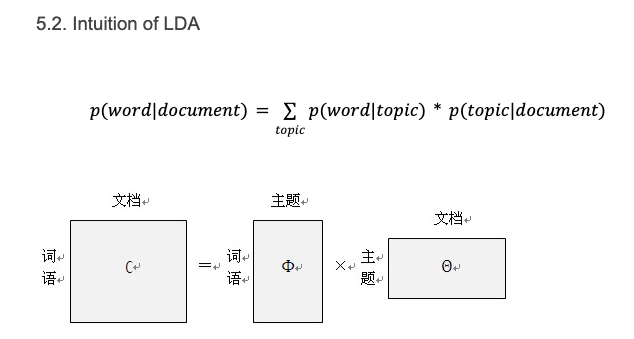

In [61]:
from sklearn.decomposition import LatentDirichletAllocation
lda_1 = LatentDirichletAllocation(n_components = 5)
lda_2 = LatentDirichletAllocation(n_components = 6)
lda_3 = LatentDirichletAllocation(n_components = 7)


In [62]:
lda_output_1 = lda_1.fit_transform(tfidf_matrix_1)
lda_output_2 = lda_2.fit_transform(tfidf_matrix_2)
lda_output_3 = lda_3.fit_transform(tfidf_matrix_3)


In [63]:

print(lda_output_2.shape)
lda_output_2

(2000, 6)


array([[0.0833334 , 0.08354432, 0.08333343, 0.08333347, 0.08333344,
        0.58312195],
       [0.083581  , 0.0836344 , 0.08349439, 0.58208624, 0.08361052,
        0.08359344],
       [0.0406467 , 0.79746948, 0.04041101, 0.04084612, 0.04043391,
        0.04019278],
       ...,
       [0.06923724, 0.0693269 , 0.65428241, 0.06904344, 0.06904348,
        0.06906653],
       [0.0693453 , 0.06944229, 0.65327693, 0.06932301, 0.06943252,
        0.06917994],
       [0.04627313, 0.76858983, 0.04602737, 0.04630287, 0.04654422,
        0.04626259]])

Generate document with topic dataframe (matrix)

In [64]:
 # column names
topic_names_1 = ["Topic" + str(i) for i in range(lda_1.n_components)]
topic_names_2 = ["Topic" + str(i) for i in range(lda_2.n_components)]
topic_names_3 = ["Topic" + str(i) for i in range(lda_3.n_components)]

# index names
doc_names_1 = ["Doc" + str(i) for i in range(len(data_1000))]
doc_names_2 = ["Doc" + str(i) for i in range(len(data_2000))]
doc_names_3 = ["Doc" + str(i) for i in range(len(data_10000))]


df_document_topic_1 = pd.DataFrame(np.round(lda_output_1, 3), columns=topic_names_1, index=doc_names_1)
df_document_topic_2 = pd.DataFrame(np.round(lda_output_2, 3), columns=topic_names_2, index=doc_names_2)
df_document_topic_3 = pd.DataFrame(np.round(lda_output_3, 3), columns=topic_names_3, index=doc_names_3)

# get dominant topic for each document
topic_1 = np.argmax(df_document_topic_1.values, axis=1)
df_document_topic_1['topic'] = topic_1


topic_2 = np.argmax(df_document_topic_2.values, axis=1)
df_document_topic_2['topic'] = topic_2

topic_3 = np.argmax(df_document_topic_3.values, axis=1)
df_document_topic_3['topic'] = topic_3

df_document_topic_1.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.500,0.061,0.060,0.063,0.316,0
Doc1,0.085,0.083,0.085,0.663,0.085,3
Doc2,0.200,0.200,0.200,0.200,0.200,0
Doc3,0.061,0.060,0.531,0.060,0.288,2
Doc4,0.038,0.038,0.847,0.038,0.038,2
Doc5,0.068,0.069,0.702,0.086,0.075,2
Doc6,0.066,0.064,0.064,0.740,0.066,3
Doc7,0.062,0.063,0.064,0.063,0.747,4
Doc8,0.815,0.047,0.046,0.046,0.046,0
Doc9,0.061,0.060,0.427,0.392,0.059,2


In [65]:
print ("Document_topic 1:")
df_document_topic_1['topic'].value_counts()


Document_topic 1:


2    419
0    172
1    160
3    154
4     95
Name: topic, dtype: int64

In [66]:
print ("Document_topic 2:")
df_document_topic_2['topic'].value_counts()


Document_topic 2:


0    533
2    369
4    345
1    334
3    245
5    174
Name: topic, dtype: int64

In [67]:
print ("Document_topic 3:")
df_document_topic_3['topic'].value_counts()


Document_topic 3:


0    2321
6    1750
4    1399
2    1357
5    1175
3    1044
1     954
Name: topic, dtype: int64

Generate topic Word dataframe (matrix)

In [68]:
topic_word_1 = lda_1.components_
topic_word_2 = lda_2.components_
topic_word_3 = lda_3.components_
print(topic_word_1.shape)
print(topic_word_1)

(5, 245)
[[0.55072262 7.67382758 0.20005486 ... 0.20317455 0.20163255 0.20247162]
 [0.2007026  0.20157408 0.20204187 ... 0.20274349 4.30367762 0.24440747]
 [1.933212   0.20288086 2.37653619 ... 1.86897797 9.47275872 4.86107712]
 [2.14345845 0.20128033 0.51908097 ... 0.71492186 1.55823052 2.01359577]
 [0.20088616 0.20182288 0.20060841 ... 3.9519616  0.20524637 5.17619556]]


In [69]:
df_topic_words_1 = pd.DataFrame(lda_1.components_, columns = tfidf_model_1.get_feature_names_out(), index = topic_names_1)
df_topic_words_2 = pd.DataFrame(lda_2.components_, columns = tfidf_model_2.get_feature_names_out(), index = topic_names_2)
df_topic_words_3 = pd.DataFrame(lda_3.components_, columns = tfidf_model_3.get_feature_names_out(), index = topic_names_3)

df_topic_words_1

,abl,absolut,accur,actual,adjust,alarm,alreadi,alway,amaz,amazon,...,weight,went,wife,wind,wish,work,worn,worth,wrist,year
Topic0,0.550723,7.673828,0.200055,0.203685,0.200875,0.201406,0.201281,0.200961,5.532975,0.806985,...,0.233718,0.201434,0.200229,0.203001,0.200705,15.428317,1.974000,0.203175,0.201633,0.202472
Topic1,0.200703,0.201574,0.202042,2.917336,0.204171,0.203413,0.206270,1.376031,0.203440,0.201693,...,2.191362,0.202848,0.201678,0.202609,0.202013,7.340018,0.204173,0.202743,4.303678,0.244407
Topic2,1.933212,0.202881,2.376536,2.254318,4.507388,0.856291,0.969181,2.806561,1.329727,3.731499,...,2.644488,1.847771,0.200770,2.959633,1.056675,10.167435,1.501927,1.868978,9.472759,4.861077
Topic3,2.143458,0.201280,0.519081,0.202856,0.201141,3.059916,4.166786,0.225967,3.471401,0.920322,...,0.201664,0.201673,3.485234,0.630363,2.843535,5.867377,0.200252,0.714922,1.558231,2.013596
Topic4,0.200886,0.201823,0.200608,0.202399,1.059135,1.546341,0.201333,0.203326,0.200965,1.147622,...,0.368284,1.207437,8.523953,0.202848,0.200827,0.404848,0.256018,3.951962,0.205246,5.176196


Print top weighted word in wach topic

In [70]:
def print_topic_words(tfidf_model, lda, n_words):
    words = np.array(tfidf_model.get_feature_names_out())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    df_topic_words = pd.DataFrame(topic_words, columns= ['Word '+str(i) for i in range(n_words)],
                                  index = ['Topic '+str(i) for i in range(lda.n_components)])

    return df_topic_words

print_topic_words(tfidf_model=tfidf_model_1, lda=lda_1, n_words=11)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,great,beauti,work,expect,gift,wear,product,absolut,deliveri,look,veri
Topic 1,nice,like,perfect,veri,color,bad,fit,got,work,pretti,look
Topic 2,good,veri,look,band,excel,qualiti,time,price,great,like,product
Topic 3,love,great,realli,price,bought,beauti,look,nice,use,easi,function
Topic 4,love,strap,broke,wife,buy,anoth,day,want,invicta,water,easili


In [71]:
print_topic_words(tfidf_model=tfidf_model_2, lda=lda_2, n_words=11)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,band,time,read,easi,hand,face,look,wrist,veri,use,like
Topic 1,good,product,qualiti,price,veri good,veri,band,great,look,ship,replac
Topic 2,love,work,excel,batteri,time,year,doe,chang,perfect,want,day
Topic 3,great,look,big,awesom,like,compliment,wrist,love,look great,price,great look
Topic 4,nice,veri,love,beauti,veri nice,thank,look,happi,veri happi,christma,buy
Topic 5,gift,veri,pleas,cute,love,cool,look,invicta,husband,veri pleas,got


In [72]:
print_topic_words(tfidf_model=tfidf_model_3, lda=lda_3, n_words=11)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,band,time,look,like,veri,hand,onli,second,use,work,wear
Topic 1,great,look,price,perfect,great price,look great,comfort,awesom,great look,wear,veri
Topic 2,time,easi,read,set,excel,use,light,easi read,day,clock,function
Topic 3,love,nice,gift,veri nice,veri,thank,husband,wife,bought,daughter,christma
Topic 4,work,batteri,receiv,like,compliment,love,look,wear,purchas,bought,realli
Topic 5,good,veri,product,qualiti,veri good,excel,beauti,price,recommend,high,expect
Topic 6,like,band,look,wrist,small,big,veri,face,size,pictur,color


## Part 6: Optimal classify

### Part 6.1 Kmeans Optimal part

In [73]:
optim_num_clusters_1 = 4

optim_km_1 = KMeans(n_clusters = optim_num_clusters_1)
optim_km_1.fit(tfidf_matrix_1)

optim_clusters_1 = optim_km_1.labels_.tolist()

optim_product_1 = { 'review': watch_df[:1000].review_body, 'cluster': optim_clusters_1}

optim_frame_1 = pd.DataFrame(optim_product_1, columns = ['review', 'cluster'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [74]:
print ("Optim Frame 1 Num Revies distribution")
optim_frame_1["cluster"].value_counts()



Optim Frame 1 Num Revies distribution


1    735
0     99
2     86
3     80
Name: cluster, dtype: int64

In [75]:



kmeans_result_output(optim_km_1, optim_num_clusters_1, tdidf_words_1, optim_frame_1)

Cluster 0 words:great,look,price,work,product,deal,comfort,love,veri,use,qualiti,year,
Cluster 0 reviews: 3 reviews : 
for my wife and she loved it, looks great and a great price!, Watch is perfect. Rugged with the metal &#34;Bull Bars&#34;. The red accents are a great touch and I get compliments when wearing it. If you are worried about being able to read this in sunlight or in the dark don't! The LED ilumination works great! I might even get this in a different color for my next G-Shock purchase!, Great quality and build.<br />The motors are really silent.<br />After fiddling with the settings my watches are always charged and ready to use.


Cluster 1 words:love,veri,look,like,band,time,work,beauti,perfect,wear,excel,realli,
Cluster 1 reviews: 3 reviews : 
Absolutely love this watch! Get compliments almost every time I wear it. Dainty., I love this watch it keeps time wonderfully., Scratches


Cluster 2 words:good,veri,product,qualiti,price,look,seller,work,excel,love,valu,big,
Clus

### Part 6.2 LDA Optimal part

In [76]:
optim_lda_1 = LatentDirichletAllocation(n_components = 4)
optim_lda_output_1 = optim_lda_1.fit_transform(tfidf_matrix_1)
optim_topic_names_1 = ["Topic" + str(i) for i in range(optim_lda_1.n_components)]
optim_doc_names_1 = ["Doc" + str(i) for i in range(len(data_1000))]
optim_df_document_topic_1 = pd.DataFrame(np.round(optim_lda_output_1, 3), columns=optim_topic_names_1, index=optim_doc_names_1)
optim_df_document_topic_1.head(10)

,Topic0,Topic1,Topic2,Topic3
Doc0,0.076,0.077,0.770,0.077
Doc1,0.108,0.106,0.680,0.106
Doc2,0.250,0.250,0.250,0.250
Doc3,0.076,0.766,0.075,0.084
Doc4,0.070,0.067,0.543,0.320
Doc5,0.085,0.087,0.740,0.087
Doc6,0.480,0.083,0.356,0.081
Doc7,0.078,0.093,0.751,0.079
Doc8,0.055,0.064,0.589,0.292
Doc9,0.213,0.077,0.632,0.078


In [77]:
optim_topic_1 = np.argmax(optim_df_document_topic_1.values, axis=1)
optim_df_document_topic_1['topic'] = topic_1

optim_df_document_topic_1.head(10)

,Topic0,Topic1,Topic2,Topic3,topic
Doc0,0.076,0.077,0.770,0.077,0
Doc1,0.108,0.106,0.680,0.106,3
Doc2,0.250,0.250,0.250,0.250,0
Doc3,0.076,0.766,0.075,0.084,2
Doc4,0.070,0.067,0.543,0.320,2
Doc5,0.085,0.087,0.740,0.087,2
Doc6,0.480,0.083,0.356,0.081,3
Doc7,0.078,0.093,0.751,0.079,4
Doc8,0.055,0.064,0.589,0.292,0
Doc9,0.213,0.077,0.632,0.078,2


In [78]:
print ("Optim Document_topic 1:")
optim_df_document_topic_1['topic'].value_counts()


Optim Document_topic 1:


2    419
0    172
1    160
3    154
4     95
Name: topic, dtype: int64

In [79]:
optim_topic_word_1 = lda_1.components_
optim_topic_word_1

array([[0.55072262, 7.67382758, 0.20005486, ..., 0.20317455, 0.20163255,
        0.20247162],
       [0.2007026 , 0.20157408, 0.20204187, ..., 0.20274349, 4.30367762,
        0.24440747],
       [1.933212  , 0.20288086, 2.37653619, ..., 1.86897797, 9.47275872,
        4.86107712],
       [2.14345845, 0.20128033, 0.51908097, ..., 0.71492186, 1.55823052,
        2.01359577],
       [0.20088616, 0.20182288, 0.20060841, ..., 3.9519616 , 0.20524637,
        5.17619556]])

In [80]:
optim_df_topic_words_1 = pd.DataFrame(optim_lda_1.components_, columns = tfidf_model_1.get_feature_names_out(), index = optim_topic_names_1)

In [81]:
optim_LDA_table = print_topic_words(tfidf_model=tfidf_model_1, lda=optim_lda_1, n_words=15)
optim_LDA_table

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,good,veri,expect,like,wife,price,qualiti,love,amaz,thank,fast,look,ship,deliveri,quick
Topic 1,work,beauti,product,great,batteri,look,day,seller,dial,qualiti,cheap,return,like,pleas,gift
Topic 2,love,great,band,look,time,wear,color,big,strap,use,veri,doe,awesom,got,buy
Topic 3,nice,perfect,veri,excel,realli,want,read,size,pictur,light,easi,exact,look,far,wrist


## Part 7: Analyze topic through the business lens


Below topic analyze is based on my personal analysis, it is a human identify process.

Kmeans model tiopic Analysis



Cluster 0： **Praise review** words:look,like,veri,band,work,time,perfect,beauti,use,great,excel,realli,

luster 1: **Praise review** words:nice,veri,price,look,simpl,realli,time,good,work,seller,great,expect,

Cluster 2:**Quality review** words:good,veri,product,qualiti,price,look,seller,work,excel,great,love,valu,

Cluster 3: **Gift/family purpose review** words:love,wife,look,husband,beauti,absolut,great,gift,veri,color,bought,son,

In [82]:
topics_analysis = ["Price/Returned customers", "Praise review", "Quality Review","Love/Couples review"]
optim_LDA_table.index=topics_analysis

optim_LDA_table

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Price/Returned customers,good,veri,expect,like,wife,price,qualiti,love,amaz,thank,fast,look,ship,deliveri,quick
Praise review,work,beauti,product,great,batteri,look,day,seller,dial,qualiti,cheap,return,like,pleas,gift
Quality Review,love,great,band,look,time,wear,color,big,strap,use,veri,doe,awesom,got,buy
Love/Couples review,nice,perfect,veri,excel,realli,want,read,size,pictur,light,easi,exact,look,far,wrist
